In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# 현재경로 확인
os.getcwd()

'C:\\Users\\Justin\\Desktop\\SSL\\FastCampus\\Shap_Value'

In [3]:
# 데이터 불러오기
data = pd.read_csv("../Data/kc_house_data.csv") 
data.head() # 데이터 확인

,id,date,price,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,yr_renovated,zipcode,lat,long
0,7129300520,20141013T000000,221900.0,3,1.00,1.0,0,3,7,1955,0,98178,47.5112,-122.257
1,6414100192,20141209T000000,538000.0,3,2.25,2.0,0,3,7,1951,1991,98125,47.7210,-122.319
2,5631500400,20150225T000000,180000.0,2,1.00,1.0,0,3,6,1933,0,98028,47.7379,-122.233
3,2487200875,20141209T000000,604000.0,4,3.00,1.0,0,5,7,1965,0,98136,47.5208,-122.393
4,1954400510,20150218T000000,510000.0,3,2.00,1.0,0,3,8,1987,0,98074,47.6168,-122.045


In [4]:
'''
id: 집 고유아이디
date: 집이 팔린 날짜 
price: 집 가격 (타겟변수)
bedrooms: 주택 당 침실 개수
bathrooms: 주택 당 화장실 개수
floors: 전체 층 개수
waterfront: 해변이 보이는지 (0, 1)
condition: 집 청소상태 (1~5)
grade: King County grading system 으로 인한 평점 (1~13)
yr_built: 집이 지어진 년도
yr_renovated: 집이 리모델링 된 년도
zipcode: 우편번호
lat: 위도
long: 경도
'''

'\nid: 집 고유아이디\ndate: 집이 팔린 날짜 \nprice: 집 가격 (타겟변수)\nbedrooms: 주택 당 침실 개수\nbathrooms: 주택 당 화장실 개수\nfloors: 전체 층 개수\nwaterfront: 해변이 보이는지 (0, 1)\ncondition: 집 청소상태 (1~5)\ngrade: King County grading system 으로 인한 평점 (1~13)\nyr_built: 집이 지어진 년도\nyr_renovated: 집이 리모델링 된 년도\nzipcode: 우편번호\nlat: 위도\nlong: 경도\n'

In [5]:
nCar = data.shape[0] # 데이터 개수
nVar = data.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 21613 nVar: 14


## 의미가 없다고 판단되는 변수 제거

In [6]:
data = data.drop(['id', 'date', 'zipcode', 'lat', 'long'], axis = 1) # id, date, zipcode, lat, long  제거

## 범주형 변수를 이진형 변수로 변환
- 범주형 변수는 waterfront 컬럼 뿐이며, 이진 분류이기 때문에 0, 1로 표현한다.
- 데이터에서 0, 1로 표현되어 있으므로 과정 생략

## 설명변수와 타겟변수를 분리, 학습데이터와 평가데이터 분리

In [7]:
feature_columns = list(data.columns.difference(['price'])) # Price를 제외한 모든 행
X = data[feature_columns]
y = data['price']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42) # 학습데이터와 평가데이터의 비율을 7:3
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 개수 확인

(15129, 8) (6484, 8) (15129,) (6484,)


## LightGBM 을 이용하여 아파트 가격 예측 (회귀)

In [8]:
import lightgbm as lgb
from math import sqrt
from sklearn.metrics import mean_squared_error
lgb_dtrain = lgb.Dataset(data = train_x, label = train_y) # 학습 데이터를 LightGBM 모델에 맞게 변환
lgb_param = {'max_depth': 10, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 1000, # Number of trees, 트리 생성 개수
            'objective': 'regression'} # 목적 함수 (L2 Loss)
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
lgb_model_predict = lgb_model.predict(test_x) # 평가 데이터 예측
print("RMSE: {}".format(sqrt(mean_squared_error(lgb_model_predict, test_y)))) # RMSE

C:\Users\Justin\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSE: 212217.42594653403


## Shap Value를 이용하여 변수 별 영향도 파악

In [17]:
# !pip install shap (에러 발생시, skimage version 확인 (0.14.2 버젼보다 최신 버젼을 권장))
# import skimage -> skimage.__version__ (skimage version 확인 방법)
# skimage version upgrade -> !pip install --upgrade scikit-image
import shap
explainer = shap.TreeExplainer(lgb_model) # 트리 모델 Shap Value 계산 객체 지정
shap_values = explainer.shap_values(test_x) # Shap Values 계산

In [18]:
shap_values

array([[   1442.88405099,   11954.0016053 ,   21670.78346839, ...,
          -4521.02309165,  -75221.13415343,    -679.89491516],
       [  48591.65053923,   24665.52576154,   65822.78060171, ...,
          -4946.08033633,  -19854.17524823,   -2398.4676219 ],
       [-139409.13118132,    9820.96153225,  -34952.54548354, ...,
         -12246.25875976,  -73125.95738312,   -4474.67965754],
       ...,
       [ -77282.73899137,  -11117.92806365,   -6640.88897006, ...,
          -3262.48303607,   45049.85249401,    -612.82861745],
       [ -99442.27182042,  -24321.08059943,   -8643.59883101, ...,
          -5769.31474346,  247790.47307466,    4058.96834225],
       [  -5958.00573936,   12164.4043741 ,  -12081.72971902, ...,
          -4142.30976824,  -78961.24247009,   -1192.42615756]])

In [19]:
shap_values.shape

(6484, 8)

In [20]:
type(test_x)

pandas.core.frame.DataFrame

In [21]:
shap.initjs() # 자바스크립트 초기화 (그래프 초기화)
shap.force_plot(explainer.expected_value, shap_values[0,:], test_x.iloc[0,:]) # 첫 번째 검증 데이터 인스턴스에 대해 Shap Value를 적용하여 시각화
# 빨간색이 영향도가 높으며, 파란색이 영향도가 낮음

In [11]:
shap.force_plot(explainer.expected_value, shap_values, test_x) # 전체 검증 데이터 셋에 대해서 적용

C:\Users\Justin\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\plots\force.py:141: UserWarning: shap.force_plot is slow for many thousands of rows, try subsampling your data.
  warnings.warn("shap.force_plot is slow for many thousands of rows, try subsampling your data.")


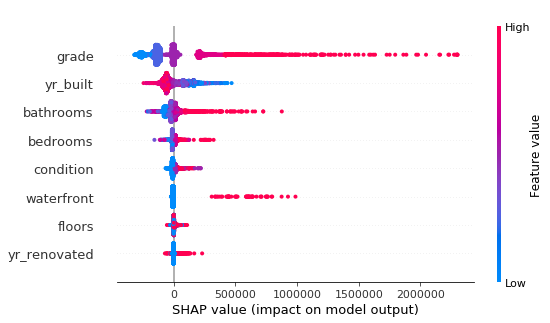

In [12]:
shap.summary_plot(shap_values, test_x)
# grade : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
# yr_built : 변수의 값이 낮을 수록, 예상 가격이 높은 경향성이 있다.
# bathrooms : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
# bedrooms : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
# condition : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다
# waterfront : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
# floors : 해석 모호성 (Feature Value에 따른 Shap Values의 상관성 파악 모호)
# yr_renovated : 해석 모호성 (Feature Value에 따른 Shap Values의 상관성 파악 모호)

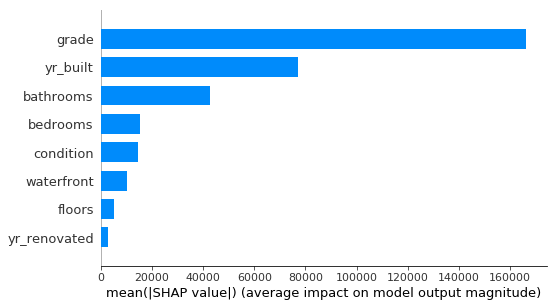

In [13]:
shap.summary_plot(shap_values, test_x, plot_type = "bar") # 각 변수에 대한 Shap Values의 절대값으로 중요도 파악